code is copied in hastings-2step

In [1]:
from numba import jit

In [2]:
from numpy import cos, sin, pi
from scipy.optimize import minimize
from random import random

@jit(nopython=True, nogil=True)
def qaoa2(beta_2, gamma_2, beta_1, gamma_1, D):
    """Cut fraction with p=2 QAOA on D-regular girth > 5 graphs"""
    c = cos(2*beta_2)
    s = sin(2*beta_2)
    m = cos(gamma_2)
    n = sin(gamma_2)
    r = cos(2*beta_1)
    t = sin(2*beta_1)
    G = cos(gamma_1)
    H = sin(gamma_1)

    A = -2*c*c*r*t*H*G**(D-1)
    bpt1 = 0.5*s*c*(
        (1 + r)*(-m*r*H - n*G)*((m*G - n*r*H)**(D-1))
        + (1 - r)*(m*r*H - n*G)*((m*G + n*r*H)**(D-1))
    )
    bpt2 = 0.5*s*c*t*(
        (m*t*(G**(D-1))*H + (1j)*n)*((m + (1j)*n*t*(G**(D-1))*H)**(D-1))
        + (m*t*(G**(D-1))*H - (1j)*n)*((m - (1j)*n*t*(G**(D-1))*H)**(D-1))
    )
    Ea = s*s*t*H * 0.5 * \
        ((1+r)*(m*G - n*H*r)**(D-1) - (1-r)*(m*G + n*H*r)**(D-1))
    Eb = (m + (1j)*n * G**(D-1) * H*t)**(D-1) + \
        (m - (1j)*n * G**(D-1) * H*t)**(D-1)
    return 0.5 - 0.5 * (A + 2*(bpt1 + bpt2) + Ea*Eb)

In [3]:
qaoa2_d_deg = lambda i, d: -qaoa2(*i, d).real

In [4]:
def get_best(d):
    best = None
    iter_times = 100 if d < 500 else 200
    for _ in range(iter_times):
        init_val = [random()*(i % 2 + 1)*pi for i in range(4)]
        result = minimize(qaoa2_d_deg, init_val, args=(d), options={'fatol': 1e-20}, method='Nelder-Mead')
        if not best or result.fun < best.fun:
            best = result
    return best

In [5]:
ds = range(2, 1000 + 1)

In [6]:
import multiprocessing
pool = multiprocessing.Pool(4)

In [7]:
%%time
results = pool.map(get_best, ds)

CPU times: user 162 ms, sys: 44.8 ms, total: 206 ms
Wall time: 5min 24s


In [8]:
out = {d: -r.fun - 0.5 for d, r in zip(ds, results)}

In [9]:
pool.close()

(0.4, 0.4745933547367115)

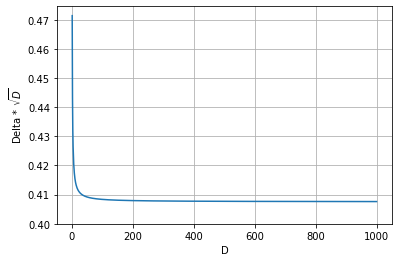

In [14]:
import matplotlib.pyplot as plt
plt.plot([k for k in sorted(out)], [out[k]*k**0.5 for k in sorted(out)])
plt.grid()
plt.xlabel("D")
plt.ylabel("Delta * $\sqrt {D} $ ")
plt.ylim(0.4)

In [11]:
import numpy as np 
sum (  np.array([out[k]*k**0.5 for k in sorted(out)]) < 0.405 )

0

In [20]:
np.array([out[k]*k**0.5 for k in sorted(out)])[-10:]

array([0.40762859, 0.40762851, 0.40762843, 0.40762834, 0.40762826,
       0.40762817, 0.40762809, 0.40762801, 0.40762792, 0.40762784])